<h2>Capstone Two: Modeling</h2>

The goal of the modeling step is to develop a final model that effectively predicts the
flow stress of different alloy plates based on known inputs prior to a pull.

Three models were developed and compared:
1) Linear Regression
2) Random Forest
3) Light Gradient Boosting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
import joblib
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Import training and testing data.

In [5]:
X_train = pd.read_parquet('../data/X_train_data.parquet')
X_test = pd.read_parquet('../data/X_test_data.parquet')
y_train_df = pd.read_parquet('../data/y_train_data.parquet')
y_test_df = pd.read_parquet('../data/y_test_data.parquet')

In [6]:
y_train = y_train_df.iloc[:, 0]
y_test = y_test_df.iloc[:, 0]

<h3>Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression Performance:")
print("RMSE:", root_mean_squared_error(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

Linear Regression Performance:
RMSE: 1444.8518588473842
MAE: 937.0297756290317
R²: 0.9756247731489034


Now base line is developed. Try Ridge Regression.

In [10]:
# Define param grids
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Ridge
ridge = Ridge(random_state=42)
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_ridge.fit(X_train, y_train)
print("Best Ridge params:", grid_ridge.best_params_)

# Lasso
lasso = Lasso(random_state=42, max_iter=10000, tol=1e-2)
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_lasso.fit(X_train, y_train)
print("Best Lasso params:", grid_lasso.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge params: {'alpha': 0.001}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Lasso params: {'alpha': 0.001}


In [11]:
models = {
    'Ridge': grid_ridge.best_estimator_,
    'Lasso': grid_lasso.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.6f}\n")


Ridge Performance:
  RMSE: 1444.8515
  MAE: 937.0218
  R²: 0.975625

Lasso Performance:
  RMSE: 1444.8516
  MAE: 937.0231
  R²: 0.975625



Same performances as linear regression. Selected Lasso predicted values for plot comparison to the actual flow stress values.

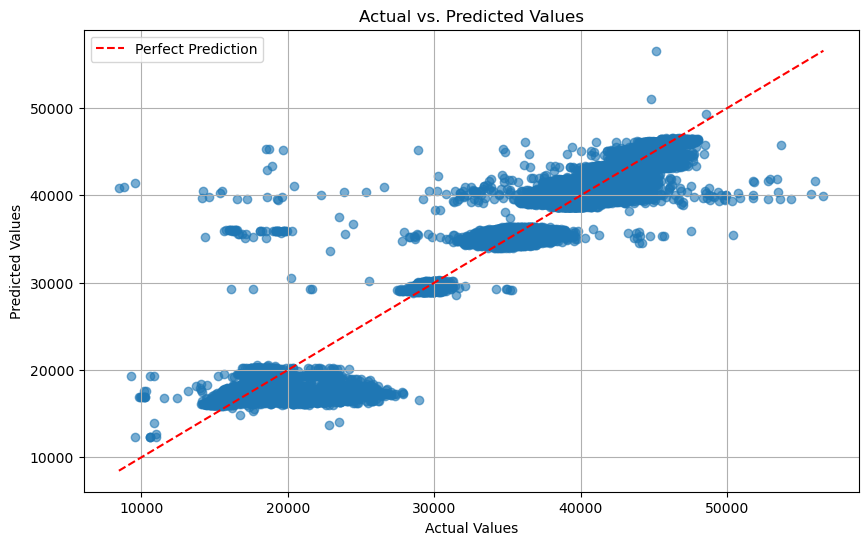

In [13]:
#Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

<h2>Random Forest</h2>

In [15]:
RUN_RF_TRAINING = False #switch to True to create a new model file.

if RUN_RF_TRAINING:
    
    # Define the model
    rf = RandomForestRegressor(random_state=42)
    
    # Define hyperparameter distributions
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
    
    # Set up RandomizedSearchCV with verbose output
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        n_jobs=1,
        random_state=42,
        scoring='neg_mean_squared_error',
        verbose=2
    )
    
    # Fit to training data
    random_search.fit(X_train, y_train)
    
    # Best hyperparameters
    print("\nBest hyperparameters:", random_search.best_params_)
    
    # Predict with best estimator
    best_rf = random_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    

In [16]:
# Save RandomForest Model
#joblib.dump(best_rf, 'best_random_forest_model.pkl')

In [17]:
# Load Best RandomForest Model
best_rf = joblib.load('best_random_forest_model.pkl')
y_pred_rf = best_rf.predict(X_test)

In [18]:
# RF Evaluation
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
ma_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Tuned Random Forest Regression Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {ma_rf:.4f}")
print(f"R²: {r2_rf:.6f}")

Tuned Random Forest Regression Performance:
RMSE: 1386.7919
MAE: 902.5501
R²: 0.977544


Slight improvement from linear, ridge, lasso regression.

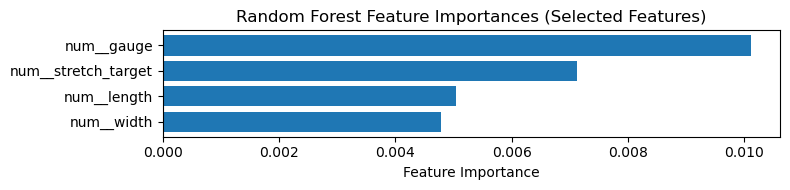

In [20]:
# Load preprocessor and model
preprocessor = joblib.load('preprocessor.pkl')
model = joblib.load('best_random_forest_model.pkl')

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Select only the features you want
selected_features = ['num__gauge', 'num__stretch_target', 'num__length', 'num__width']

# Get indices of selected features in the full feature list
indices = [list(feature_names).index(f) for f in selected_features]

# Extract importances and names for selected features
importances = best_rf.feature_importances_
selected_importances = importances[indices]
selected_names = feature_names[indices]

# Sort by importance
sorted_idx = np.argsort(selected_importances)

plt.figure(figsize=(8, 2))
plt.barh(range(len(selected_importances)), selected_importances[sorted_idx])
plt.yticks(range(len(selected_importances)), np.array(selected_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances (Selected Features)")
plt.tight_layout()
plt.show()


Feature with most importance is the gauge.

Test of single example for backchecking.

In [23]:
# Define input
example = pd.DataFrame([{
    'gauge': 6.0,
    'width': 56.0,
    'length': 340.0,
    'stretch_target': 2.0,
    'alloy': 'XVKKT7H51'
}])

# Transform the example input using the same preprocessor
example_transformed = preprocessor.transform(example)

# Predict
prediction_rf = model.predict(example_transformed)

# Output the result
print("Prediction with RF:", prediction_rf[0].round(0))

Prediction with RF: 40781.0


Regression models are predicting the average values for each alloy. Client needs to know the worst case scenarios. Try prediction model that allows for quantile percent adjustment.

<h2> Light Gradient Boosting</h2>

Predict based on the 99th percentile of the plates.

In [27]:
RUN_LGB_TRAINING = False #switch to True to create a new model file.

if RUN_LGB_TRAINING:
    # Define the model
    lgb_model = LGBMRegressor(
        objective='quantile',
        alpha=0.99,
        boosting_type='gbdt',
        metric='quantile',
        verbose=2
    )
    
    # Define parameter grid
    param_dist = {
        'num_leaves': [15, 31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_samples': [10, 20, 30, 50],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [-1, 5, 10, 15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    # Randomized search
    random_search = RandomizedSearchCV(
        lgb_model,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_mean_absolute_error',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # Fit search
    random_search.fit(X_train, y_train)
    
    # Best model
    best_lgb = random_search.best_estimator_
    
    # Predict upper quantile
    y_pred_lbg = best_lgb.predict(X_test)
    
    # Print best parameters
    print("Best parameters:", random_search.best_params_)


In [28]:
#joblib.dump(model, 'model_Xth_percentile.pkl')

In [29]:
# Load Best Light Gradient Boosting Model
best_lgb = joblib.load('model_Xth_percentile.pkl')
y_pred_lgb = best_lgb.predict(X_test)

In [30]:
# LGB Evaluation
rmse_lgb = root_mean_squared_error(y_test, y_pred_lgb)
ma_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\nTuned Random Forest Regression Performance:")
print(f"RMSE: {rmse_lgb:.4f}")
print(f"MAE: {ma_lgb:.4f}")
print(f"R²: {r2_lgb:.4f}")


Tuned Random Forest Regression Performance:
RMSE: 4881.9565
MAE: 3836.9516
R²: 0.7217


Not surprised the performance shows lower prediction metrics. The scatter of prediction vs actual should show the predictions are higher now that it is focusing on the 99th percentile.

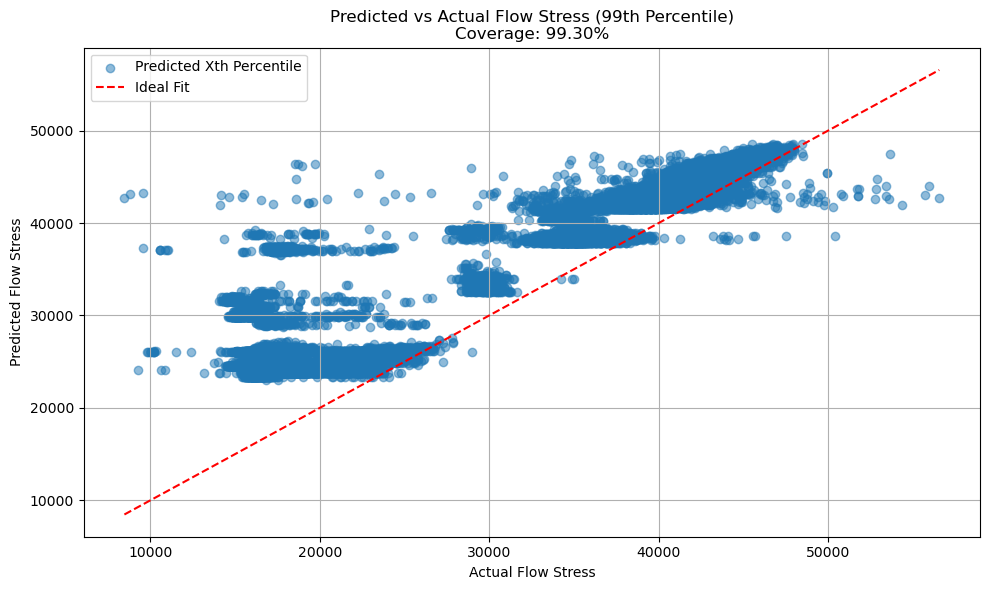

In [32]:
# Calculate coverage
coverage = (y_test <= y_pred_lgb).mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.5, label='Predicted Xth Percentile')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Flow Stress')
plt.ylabel('Predicted Flow Stress')
plt.title(f'Predicted vs Actual Flow Stress (99th Percentile)\nCoverage: {coverage:.2f}%')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The data points are clearly shifted towards predicted. Showing the efforts of predicting for the 99th percentile.

Check same example from RF. Prediction of example is higher than the RF prediction.

In [35]:
# Define input
example = pd.DataFrame([{
    'gauge': 6.0,
    'width': 56.0,
    'length': 340.0,
    'stretch_target': 2.0,
    'alloy': 'XVKKT7H51'
}])

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame with feature names
example_transformed_df = pd.DataFrame(example_transformed.toarray(), columns=feature_names)

# Predict
prediction_lgb = best_lgb.predict(example_transformed_df)

# Output the result
print("Prediction:", prediction_lgb[0].round())

Prediction: 43313.0


<h2>Verification Plots for Client</h2>

The client needs a way to visualize how these predictions compare to historical data. These plots shows the predictions for all alloy and gauge combination found from the historial data. The LGB model does use lenght, width, and stretch target for prediction precission. However, the client is used to seeing the gauge vs flow_stress scatter plots and gauge is the feature of greatest importance after alloy type. Therefore, these plots are great visualization for relaying the model performance.

In [38]:
# Extract the StandardScaler from the 'num' transformer
scaler = preprocessor.named_transformers_['num']

In [39]:
# Combine X_test and y_test into a single DataFrame for easy filtering
df_lgb = X_test.copy()
df_lgb['flow_stress_actual'] = y_test_df
df_lgb['flow_stress_pred'] = y_pred_lgb

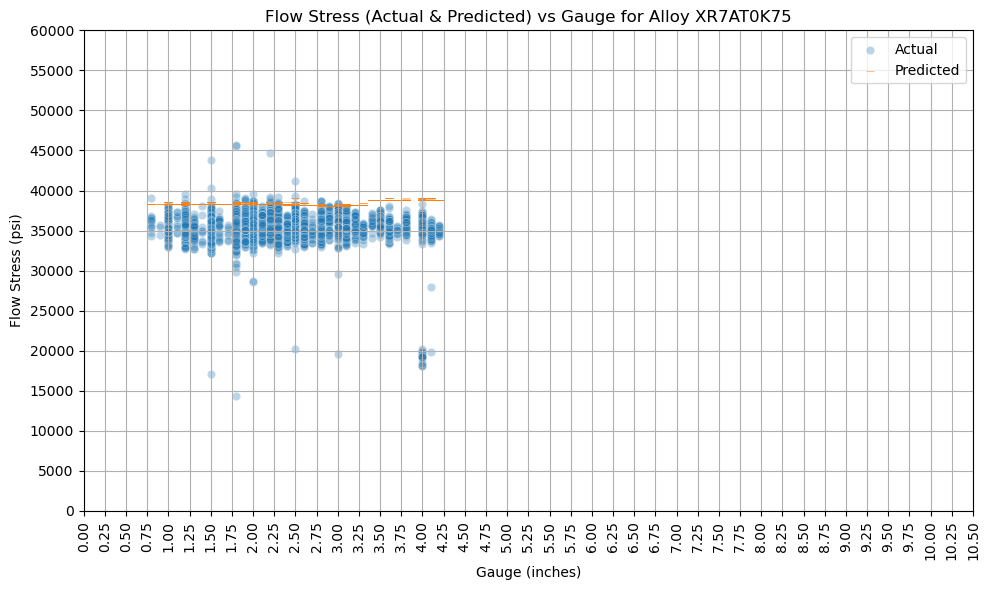

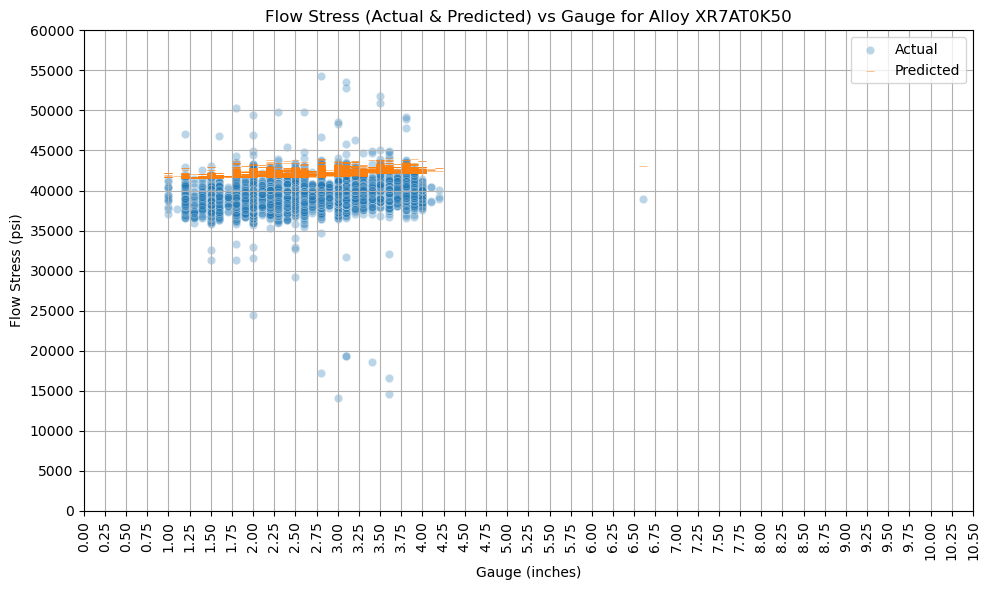

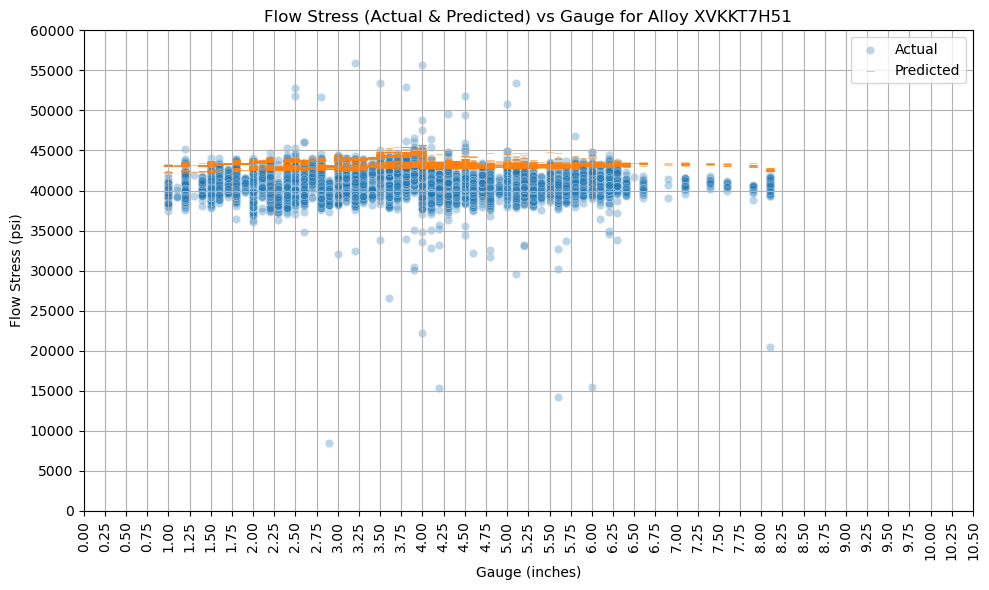

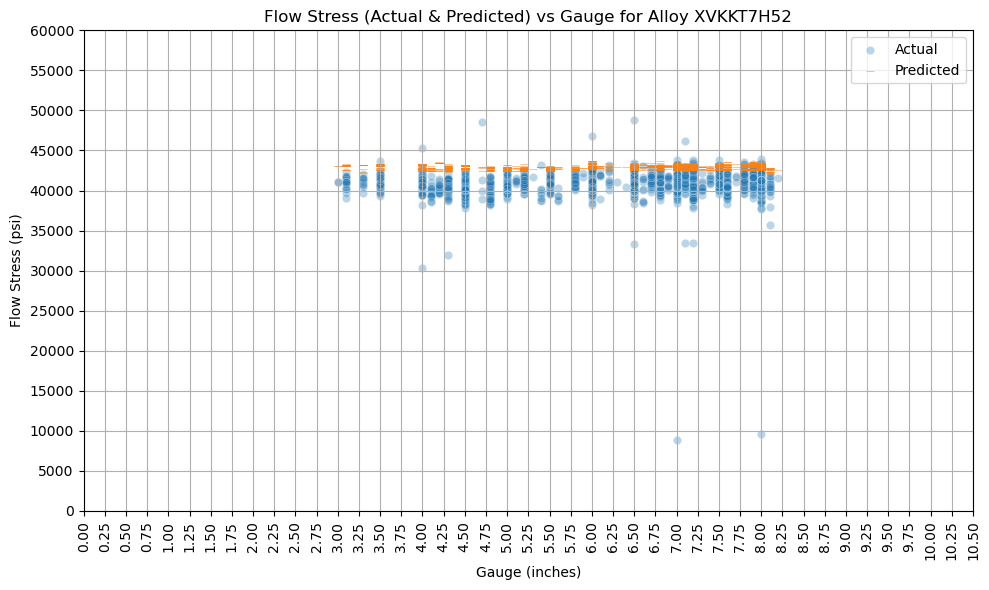

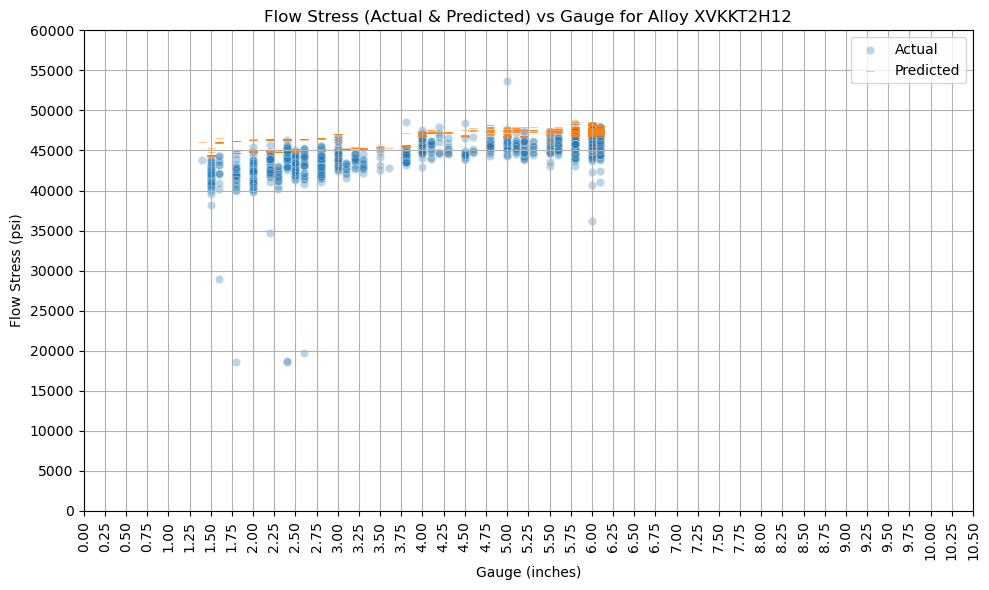

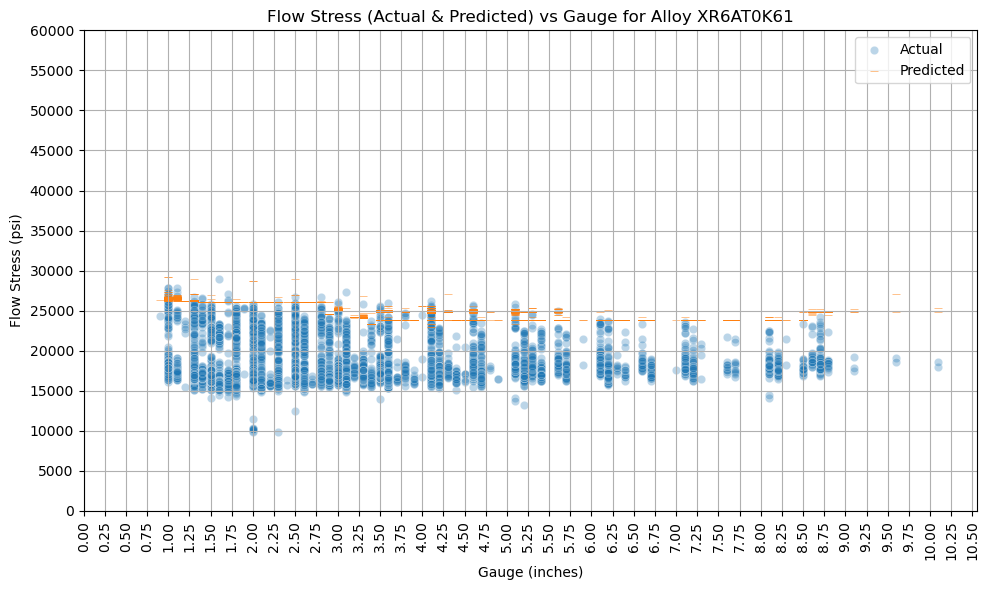

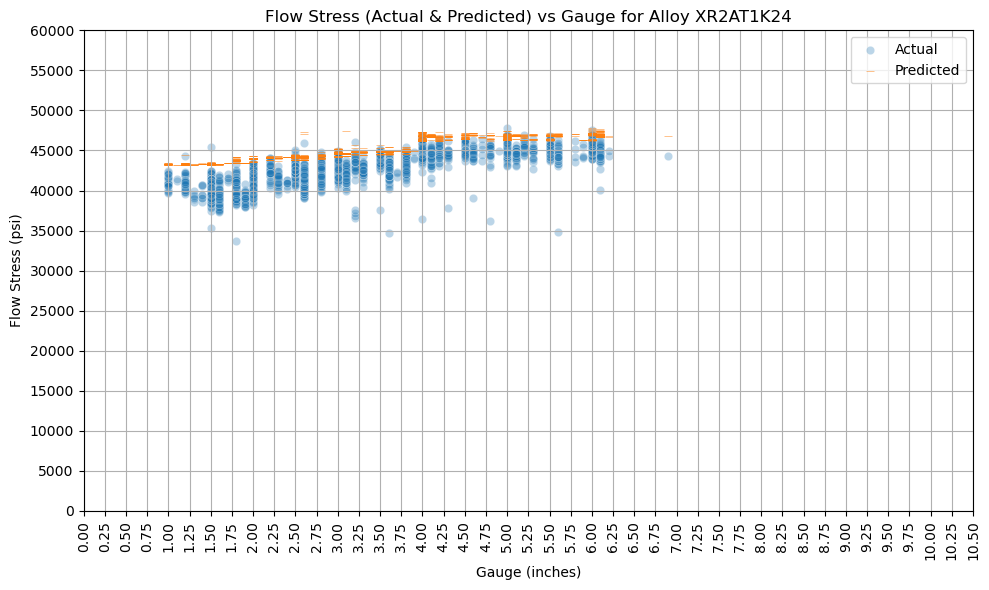

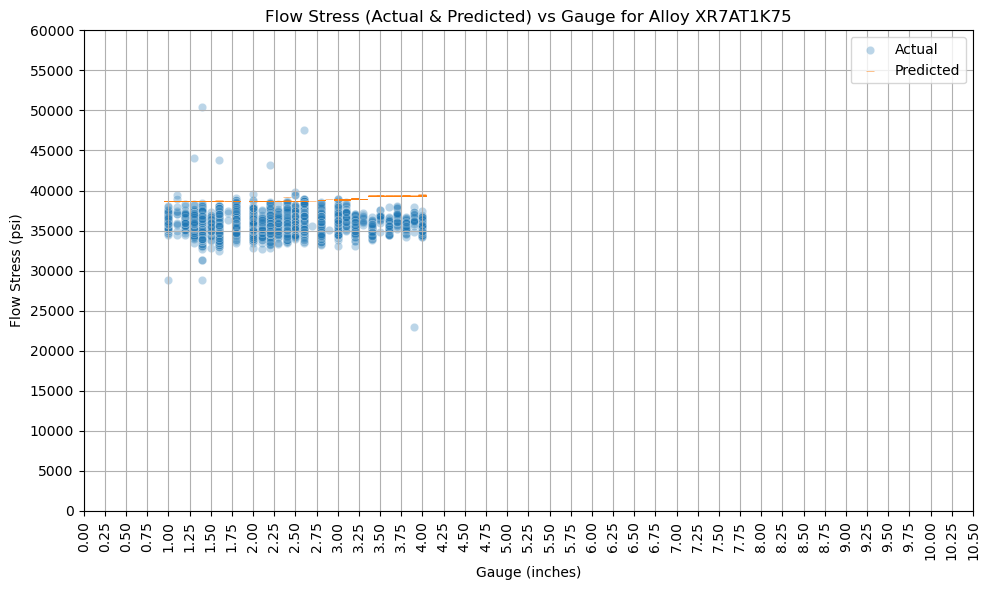

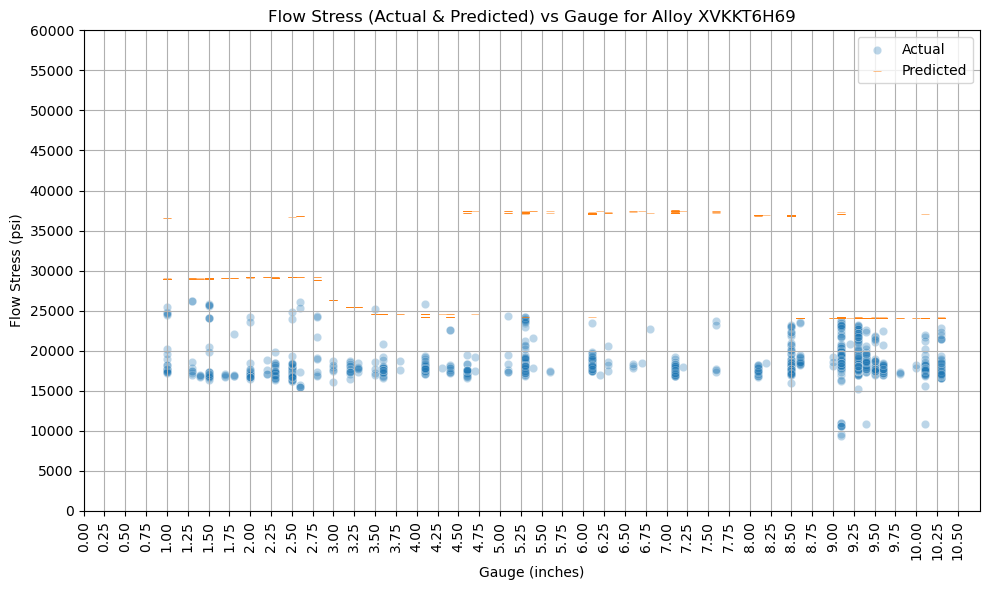

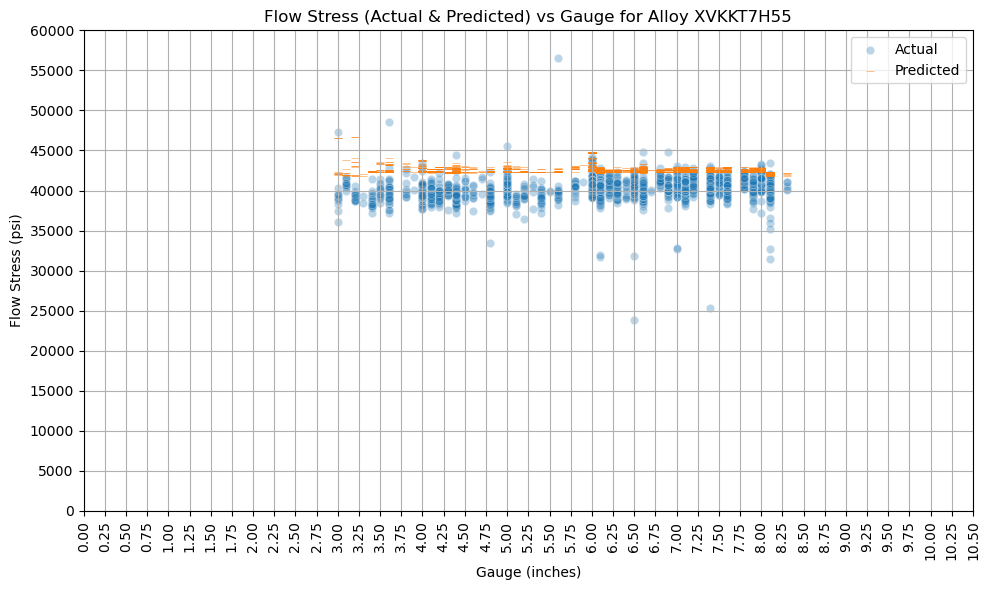

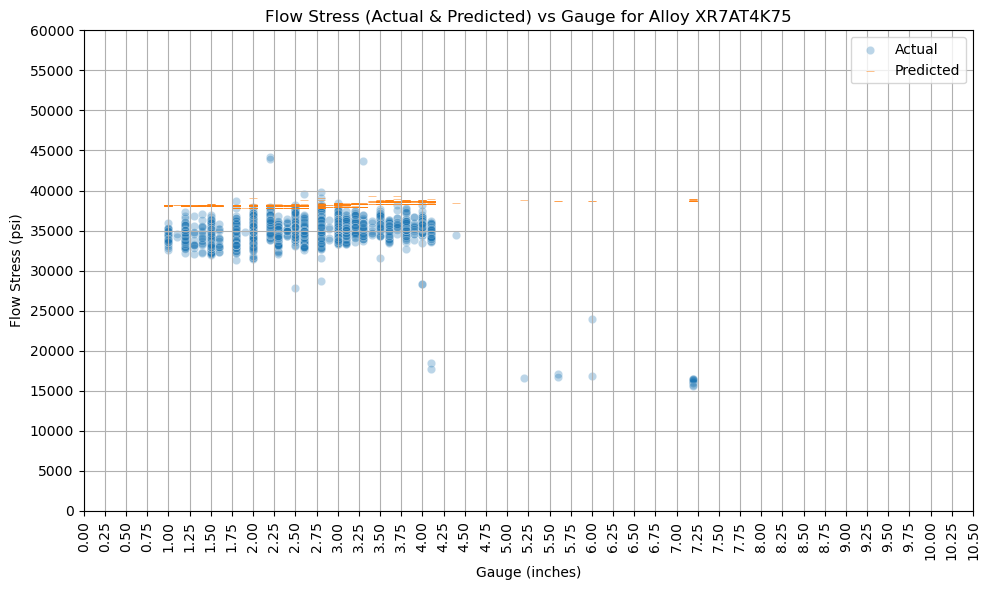

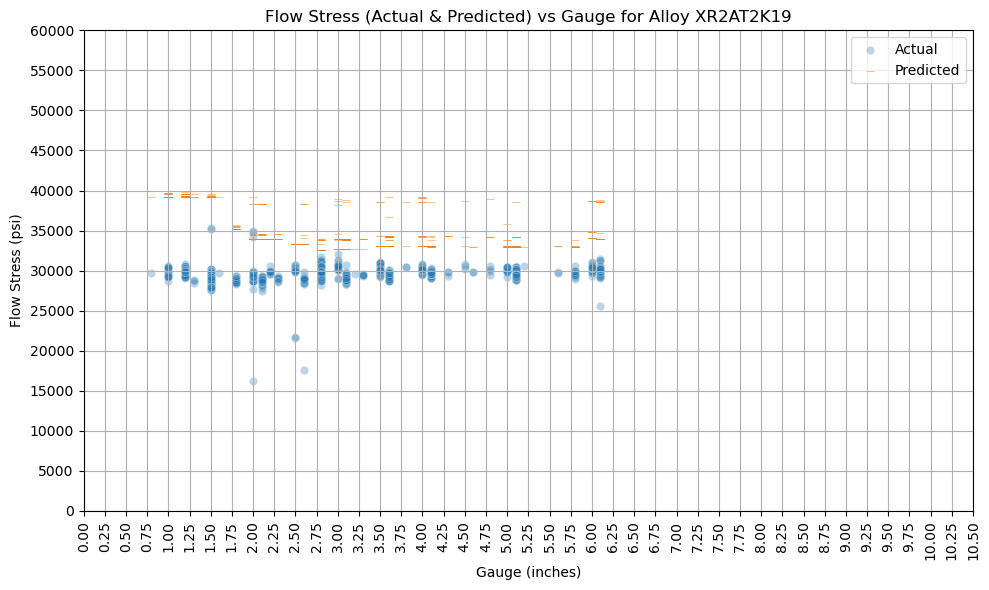

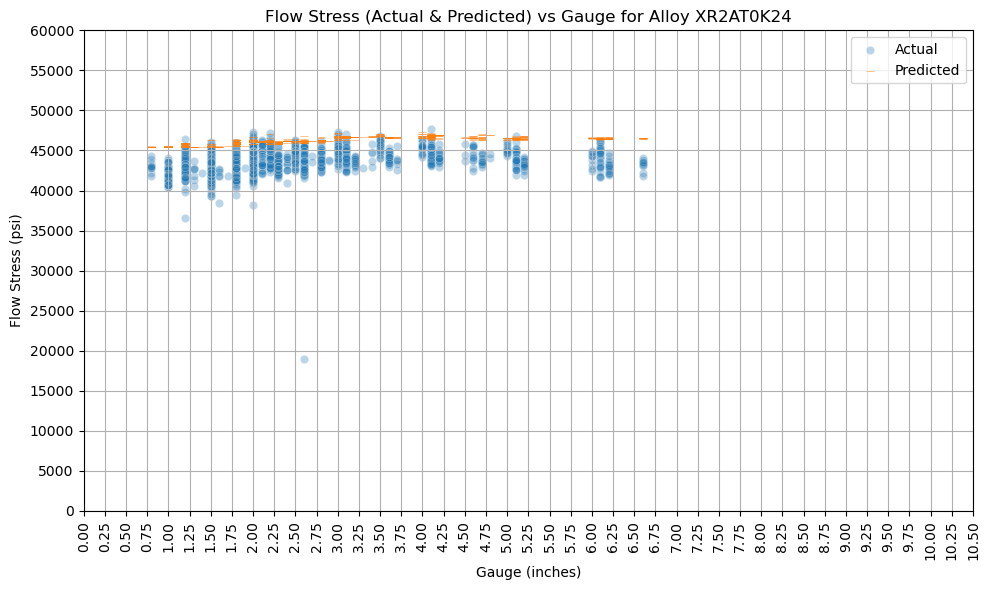

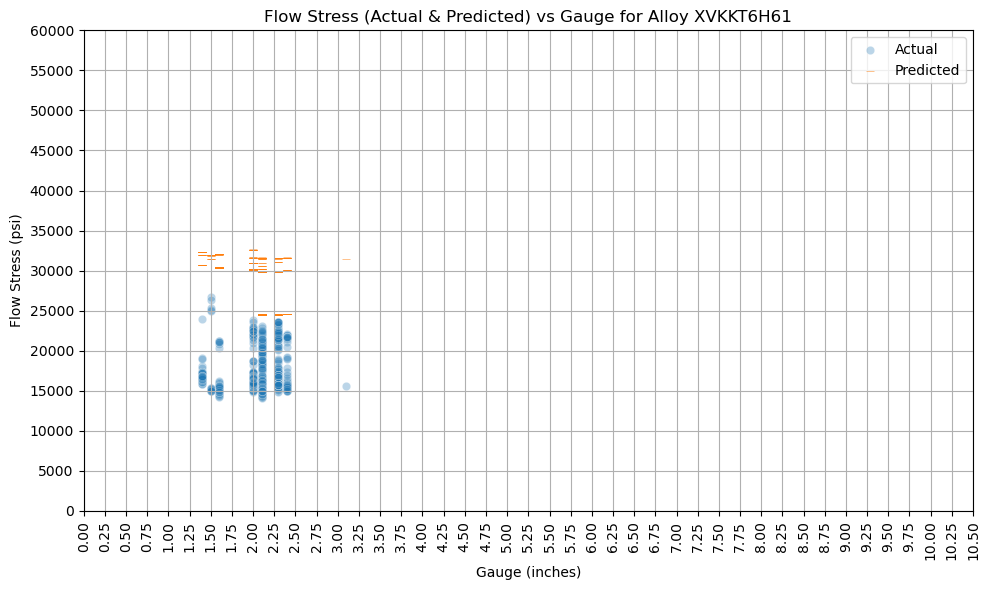

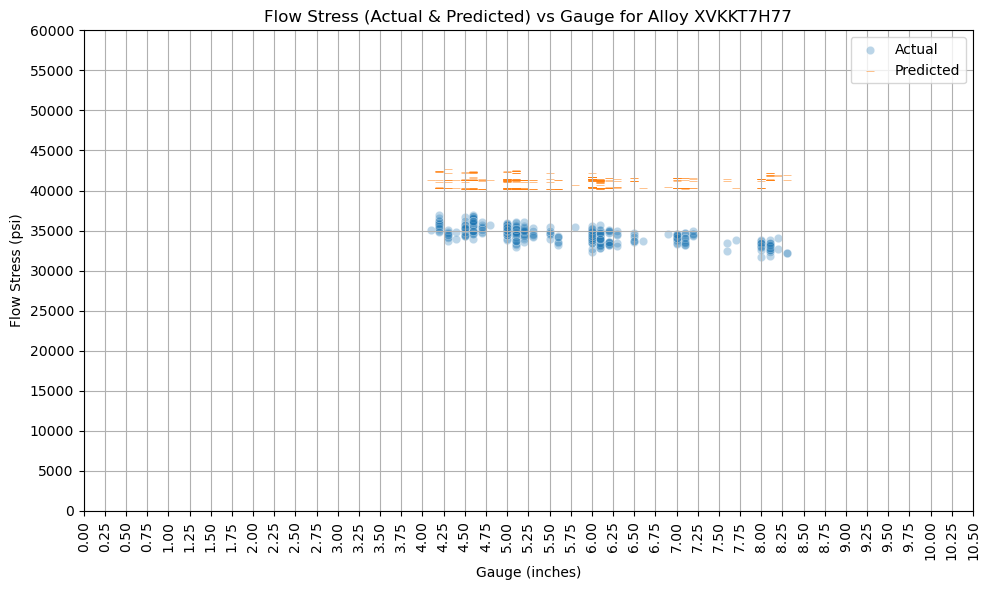

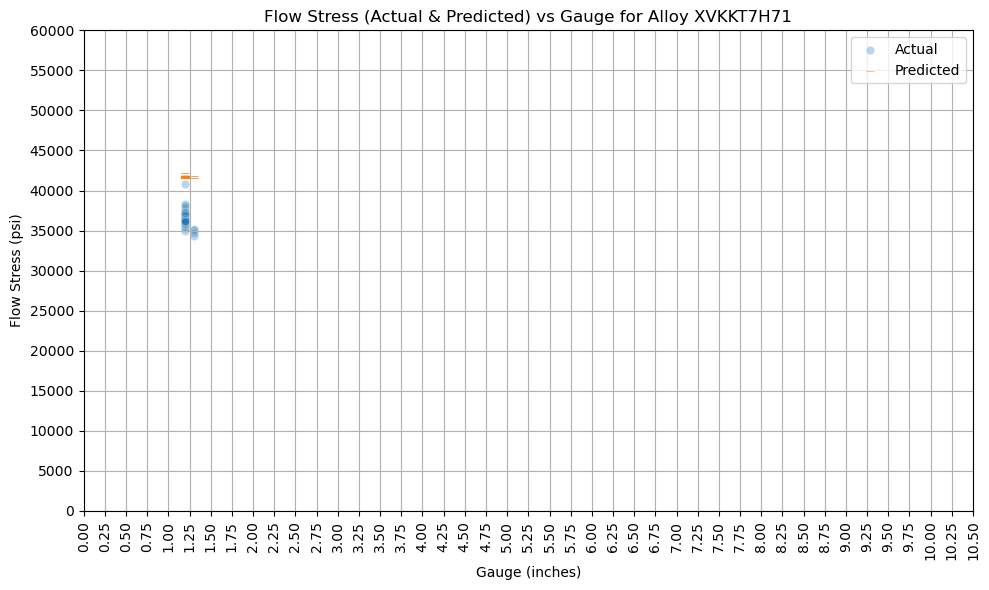

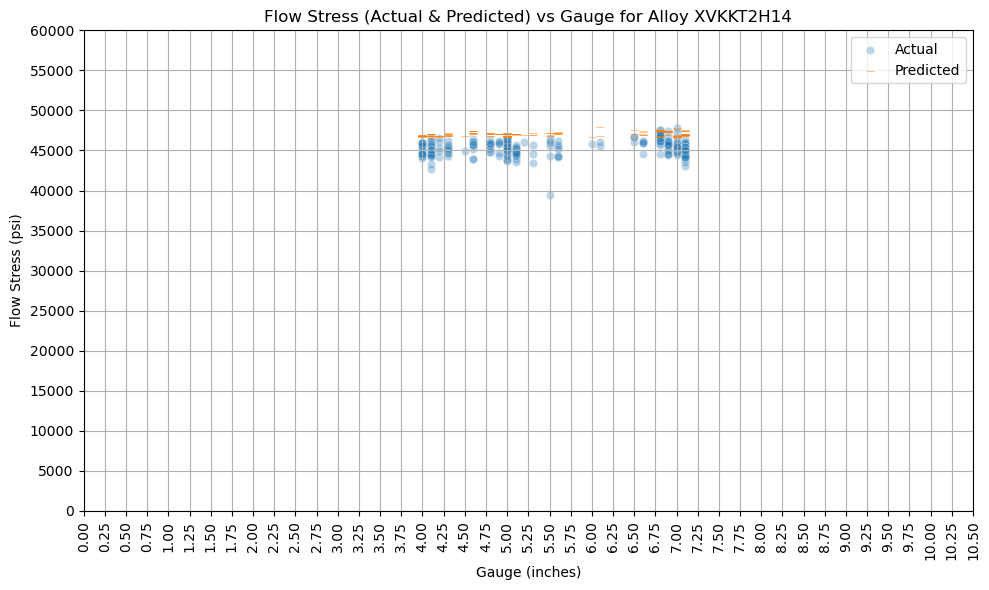

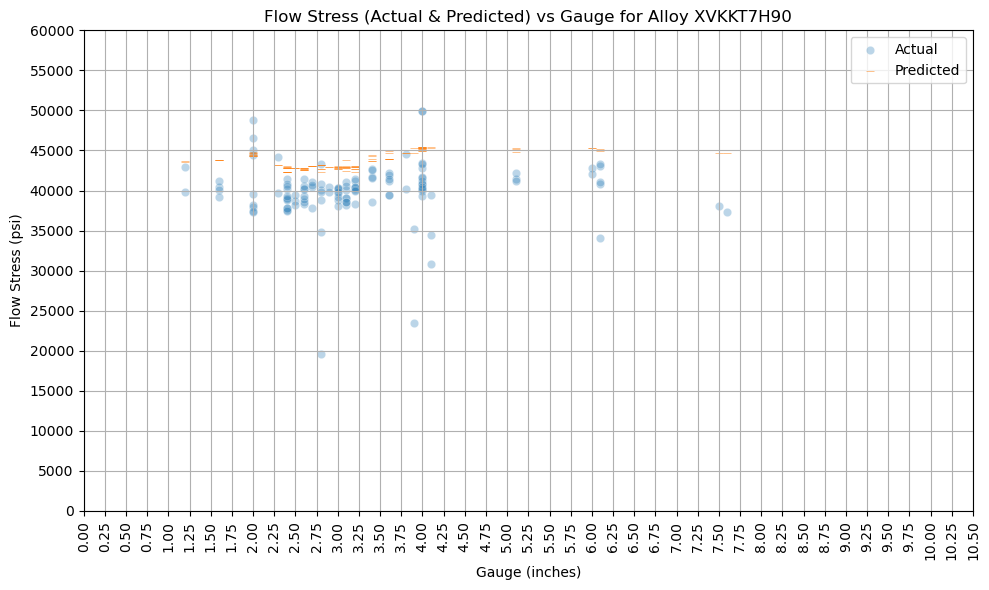

In [40]:
# Get the alloy columns
alloy_cols = [col for col in df_lgb.columns if col.startswith('cat__alloy_')]

# Create a new column for alloy name
df_lgb['alloy'] = df_lgb[alloy_cols].idxmax(axis=1).str.replace('cat__alloy_', '')

# Inverse transform the numeric features
num_features = ['num__gauge', 'num__width', 'num__length', 'num__stretch_target']
X_num_unscaled = scaler.inverse_transform(df_lgb[num_features])
df_lgb[['gauge', 'width', 'length', 'stretch_target']] = X_num_unscaled

# Loop through each alloy and plot
for alloy in df_lgb['alloy'].unique():
    subset = df_lgb[df_lgb['alloy'] == alloy]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset, x='gauge', y='flow_stress_actual', label='Actual', alpha=0.3)
    sns.scatterplot(data=subset, x='gauge', y='flow_stress_pred', label='Predicted', alpha=0.7, marker='_')

    plt.xlabel('Gauge (inches)')
    plt.ylabel('Flow Stress (psi)')
    plt.xticks(np.arange(0, 10.75, 0.25), rotation=90)
    plt.yticks(np.arange(0, 65000, 5000))
    plt.title(f'Flow Stress (Actual & Predicted) vs Gauge for Alloy {alloy}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


<h2>Summary:</h2>

These predictions are a great start. Approval to client has been submitted. Recommendations based on observations would be:
1) Alloys with smaller counts are predicting higher at a 99% quantile.
2) Alloys with historical radical flow stresses are predicting lower at 99% quantile.
3) Quantile percent could be adjusted per alloy for additional refinement.

Graphs indicant that Light Gradient Boosting is the best model for this applications based on the ones tested.